In [1]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR == Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is a result of some operation, then create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [2]:
import math

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):   # This basically allows us to print nicer looking expressions for the final output
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        return out

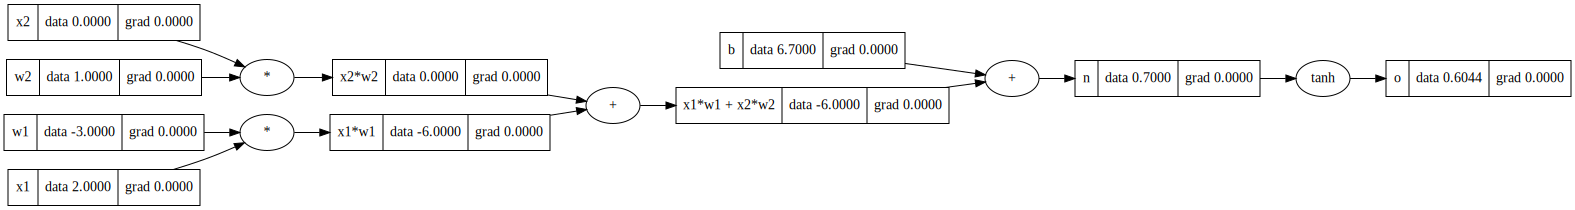

In [ ]:
#What the graph looks like right now, the grad values are set to 0
draw_dot(o)

----------

We'll be adding a 'backward' function to our Value object and then implement its functionality in each of the operation function. \
\
We are basically converting everything we did manually to calculate the gradients in each operation to code :)

In [29]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #Its an empty function by default. This is what will do that gradient calculation at each of the operations.
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):   # This basically allows us to print nicer looking expressions for the final output
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
          self.grad = 1.0 * out.grad  #Remember we are doing chain rule here, hence the product with out.grad
          other.grad = 1.0 * out.grad

        out._backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
          self.grad = other.data * out.grad #Remember we are doing chain rule here, hence the product with out.grad
          other.grad = self.data * out.grad

        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
          self.grad = 1 - (t**2) * out.grad #Remember we are doing chain rule here, hence the product with out.grad

        out._backward = backward
        return out

In [32]:
#Inputs x1, x2 of the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights w1, w2 of the neuron - The synaptic values
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#The bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

#The summation
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

#n is basically the cell body, but without the activation function
n = x1w1x2w2 + b; n.label = 'n'

#Now we pass n to the activation function
o = n.tanh(); o.label = 'o'

Now, we call the '_backward' function that we have made one by one in order (backwards through the equation/graph) \
\
But before we could do that, we have to first set the value of o.grad to 1.0 \
As notice in the Value object code that, we have initialised it to 0 \
\
Therefore, we'll start by adding o.grad to 1.0 and then we'll call the '_backward' function rest of them one by one

In [33]:
o.grad = 1.0

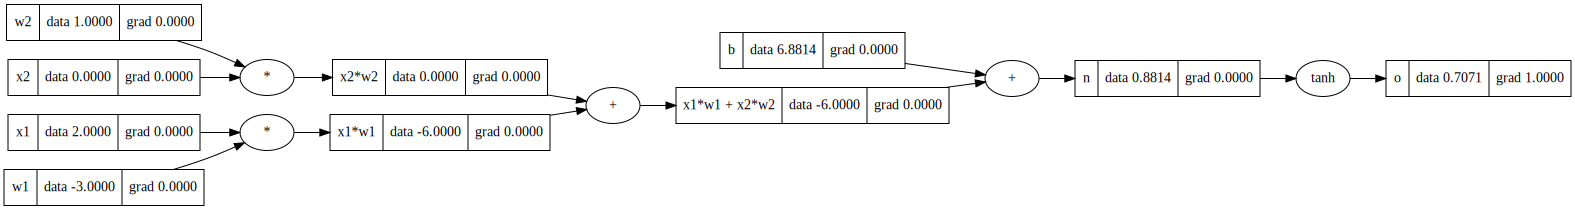

In [34]:
draw_dot(o)

Now. we go with o

In [35]:
o._backward()

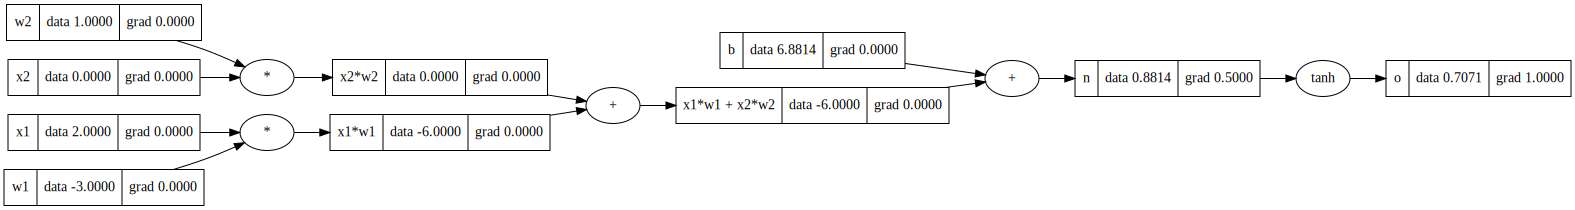

In [36]:
draw_dot(o)

Now, from n

In [37]:
n._backward()

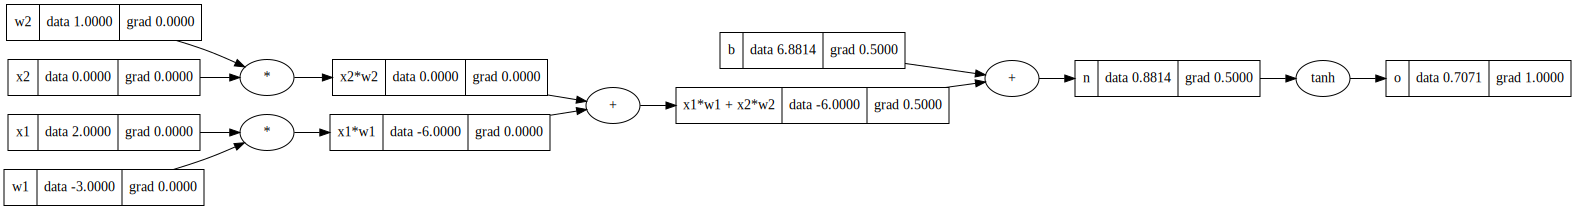

In [38]:
draw_dot(o)

Now, b is a leaf node so we just leave it there (Another reason why _backward was initiallised to None function, it's because it won't be called for leaf nodes. Therefore we set it to None for them) \
\
We'll continue with x1w1x1w2

In [39]:
x1w1x2w2._backward()

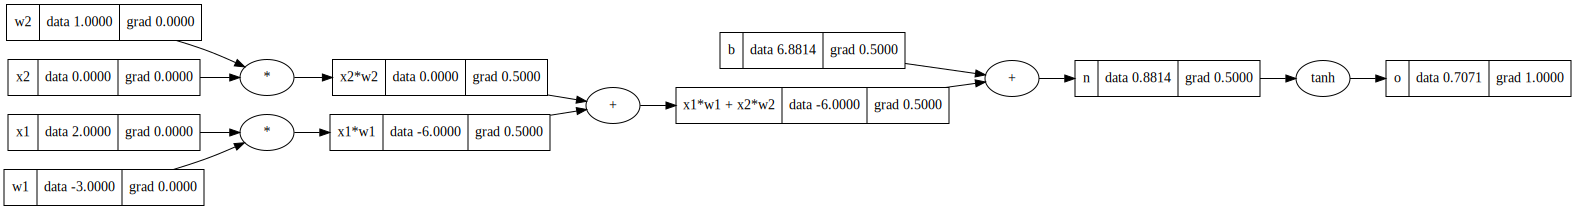

In [40]:
draw_dot(o)

Now finally, to finding the gradient of the intial values

In [41]:
x1w1._backward()
x2w2._backward()

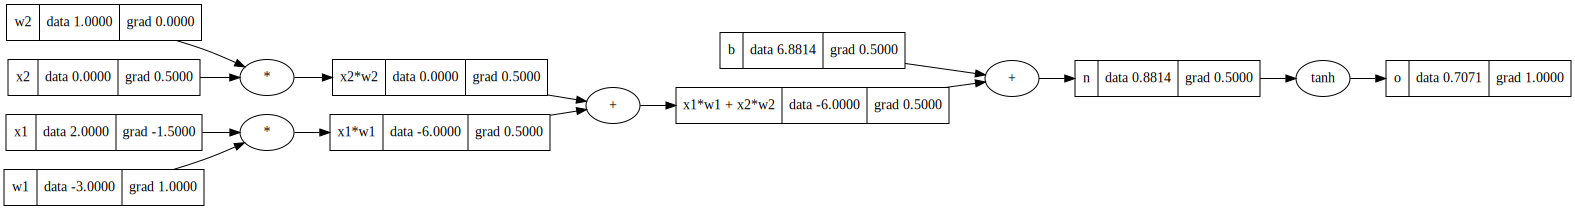

In [42]:
draw_dot(o)

----------------

### **Final output^**

Hence, we have not only verified the manual backpropagation calculation that we did, but also created funtions directly for each of them!